# Wang Landau algorithm

In [1]:
from numpy import *
from numpy import random
from numba import jit

@jit(nopython=True)
def CEnergy(latt):
    "Energy of configuration for the 2D Ising model"
    N = shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]   # Spin, can be either +1 or -1
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.

def RandomL(N):
    "Random lattice corresponding to infinite temperature"
    return array(sign(2*random.random((N,N))-1),dtype=int) 

In [6]:
def PrepareEnergies(N):
    Energies = (array(4*arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist() # -2 N^2...2N^2 in steps of 4
    Energies.pop(1)  # take out E[1]
    Energies.pop(-2) # take out E[-2]
    Energies = array(Energies) # make array of energies again
    Emin, Emax = Energies[0],Energies[-1]
    #index array to energies
    indE = -ones(Emax+1-Emin, dtype=int) # index table to get index to particular energy g(E)~g[indE[E]]
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    # Ising lattice at infinite T
    return (Energies, indE, Emin)

In [8]:
Ene,indE,Emin = PrepareEnergies(10)
print('Emin=',Emin)
print(Ene)
print(indE)

Emin= -200
[-200 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144
 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100  -96  -92  -88
  -84  -80  -76  -72  -68  -64  -60  -56  -52  -48  -44  -40  -36  -32
  -28  -24  -20  -16  -12   -8   -4    0    4    8   12   16   20   24
   28   32   36   40   44   48   52   56   60   64   68   72   76   80
   84   88   92   96  100  104  108  112  116  120  124  128  132  136
  140  144  148  152  156  160  164  168  172  176  180  184  188  192
  200]
[ 0 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  2 -1 -1 -1  3 -1 -1 -1  4 -1 -1 -1
  5 -1 -1 -1  6 -1 -1 -1  7 -1 -1 -1  8 -1 -1 -1  9 -1 -1 -1 10 -1 -1 -1
 11 -1 -1 -1 12 -1 -1 -1 13 -1 -1 -1 14 -1 -1 -1 15 -1 -1 -1 16 -1 -1 -1
 17 -1 -1 -1 18 -1 -1 -1 19 -1 -1 -1 20 -1 -1 -1 21 -1 -1 -1 22 -1 -1 -1
 23 -1 -1 -1 24 -1 -1 -1 25 -1 -1 -1 26 -1 -1 -1 27 -1 -1 -1 28 -1 -1 -1
 29 -1 -1 -1 30 -1 -1 -1 31 -1 -1 -1 32 -1 -1 -1 33 -1 -1 -1 34 -1 -1 -1
 35 -1 -1 -1 36 -1 -1 -1 37 -1 -1 -1 38 -1 -1 -

In [4]:
from numpy import random
def WangLandau(Nitt, N, flatness):
    "Wang Landau in Python"
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)
    return RunWangLandau(Nitt,Energies,latt,indE)

In [9]:
@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    #min,maximum energy
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = zeros(len(Energies))
    # Histogram
    Hist = zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) # the energy change if we flip the spin
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]]
        lgold = lngE[indE[Ene-Emin]]
        P = 1.0
        if lgold-lgnew < 0 : P=exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', exp(lnf))
    return (lngE, Hist, Energies)

In [10]:
from numpy import random

flatness = 0.9
N = 20
Nitt = int(100e6)

#N=10
#Nitt = int(10e6)

(lngE, Hist, Energies) = WangLandau(Nitt, N, flatness)

10649999 histogram is flat 24269.0 26625.0 f= 1.6487212707001282
13240999 histogram is flat 5840.0 6477.5 f= 1.2840254166877414
15756999 histogram is flat 5673.0 6290.0 f= 1.1331484530668263
18197999 histogram is flat 5495.0 6102.5 f= 1.0644944589178593
20460999 histogram is flat 5104.0 5657.5 f= 1.0317434074991028
22623999 histogram is flat 4874.0 5407.5 f= 1.0157477085866857
25381999 histogram is flat 6222.0 6895.0 f= 1.007843097206448
28732999 histogram is flat 7571.0 8377.5 f= 1.0039138893383475
33813999 histogram is flat 11457.0 12702.5 f= 1.0019550335910028
41300999 histogram is flat 16862.0 18717.5 f= 1.0009770394924165
49078999 histogram is flat 17505.0 19445.0 f= 1.0004884004786945
60349999 histogram is flat 25418.0 28177.5 f= 1.0002441704297478
70789999 histogram is flat 23491.0 26100.0 f= 1.0001220777633837
92226999 histogram is flat 48270.0 53592.5 f= 1.0000610370189331


In [12]:
# Proper normalization of the Density of states
# g *= 4/(g[0]+g[-1])
# log(g) += log(4)-log(g[-1])-log(1+exp(log(g[0])-log(g[-1])))
# 
if lngE[-1]>lngE[0]:
    lgC = log(4)-lngE[-1]-log(1+exp(lngE[0]-lngE[-1]))
else:
    lgC = log(4)-lngE[0]-log(1+exp(lngE[-1]-lngE[0]))
    
lngE += lgC

In [13]:
exp(lngE[0])+exp(lngE[-1])

4.0

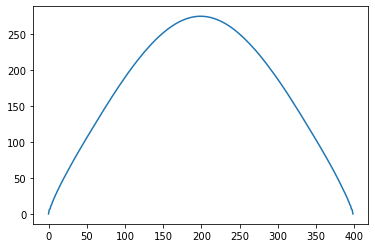

In [14]:
from pylab import *
%matplotlib inline

plot(lngE)

In [17]:
def Thermod(T, lngE, Energies, N):
    Z = 0.
    Ev = 0.  # <E>
    E2v = 0. # <E^2>
    for i,E in enumerate(Energies):
        w = exp(lngE[i]-lngE[0]-(E-Energies[0])/T) # g(E)/g0 Exp(-(E-E0)/T)
        Z += w
        Ev += w*E
        E2v += w*E**2
    Ev *= 1./Z
    E2v *= 1./Z
    cv = (E2v-Ev**2)/T**2
    return (Ev/(N**2), cv/(N**2))

In [18]:
Te = linspace(0.5,4.,300)

Thm=[]
for T in Te:
    Thm.append(Thermod(T, lngE, Energies, N))
Thm = array(Thm)

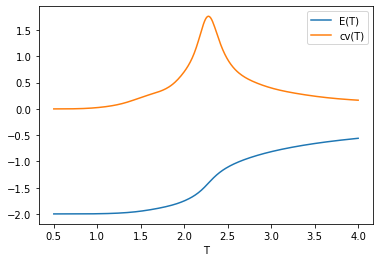

In [19]:
from pylab import *
%matplotlib inline

plot(Te, Thm[:,0], label='E(T)')
plot(Te, Thm[:,1], label='cv(T)')
xlabel('T')
legend(loc='best')
show()

## Homework

* Estimate the error of the density of states $log(g(E))==S(E)$ for 32x32 Ising model. 

To do that, you can use five independent runs of WL agorithm, which will produce $S_i(E)$ for i=1..5. 
In each WL run use $10^9$ Monte Carlo steps. From the series of $S_i(E)$ you can calculate 
\begin{eqnarray}
&& <S(E)> = \frac{1}{n} \sum_{i=1}^n S_i(E) \\
&& \sigma_E = \sqrt{\frac{<S^2(E)>-<S(E)>^2}{n}} = \sqrt{\frac{1}{n^2} \sum_{i=1}^n (S_i(E)-<S(E)>)^2}
\end{eqnarray}

Plot $S_i(E)-<S(E)>$ and $\sigma_E$. 

* According to the publication "Exact Distribution of Energies in the Two-Dimensional Ising Model", PRL 76, 78 (1995), the first 10 values for the density of states in 32x32 Ising model is:
$g_{Exact}=[2,2048,4096,1057792,4218880,371621888,2191790080,100903637504,768629792768,22748079183872]$

Plot $<S(E)>$ and $log(g_{exact})$ for the first 10 coefficients, as well as their difference.

Verify if your estimated $<S(E)>$ is approximately $\sigma_E$ from exact result. To do that, plot $<S(E)>-S_{exact}$ and $\sigma_E$ for the first 10 energies.

* Calculate thermodynamics from your best estimation of $g(E)$.